## Modelling Problem

### <font color=green><strong操作使用本project指南：（这里设置好了可以直接点击全部运行，如果运行不了可能要检查下，麻烦联系我！+v:landislotus）Python 3.10.9 <strong></font>
1. Cell 3，5: 加载包和预置文件环境

2. Cell 6: 这里可以放入数据, 在df处更换，并查看index, label和asset数量

3. Cell 8: 检查整个数据集有无missing value，有的话进行数据处理先（这个project暂时没有）
4. Cell 9: 检查lable，每列的名字，这里数据集拆开multiindex后各列的名字是['Close_time', 'Asset_id', 'Open', 'High', 'Low', 'Close', 'Volume']，如果不同的数据集，不同的列名的话请在后面单元格依次修改，只用修改名字即可。（其实可以用表达式来表达列的名字的，但我没时间做了，以后做脚本可以直接添加列的填入选项，更方便）
5. Cell 15：转换5 minutes returning rate
6. Cell 20: 检查boxplot有无outlier，如果很大需要先用平均数代替处理，或者interpolate也可以
7. Cell 27-30: 检查有无missing值，如果有的话会输出行和列的missing位置，并且会填充。
8. Cell 34：plot检查是否符合正态分布
9. Cell 38：标准化数据5 minutes returning rate
10. Cell 52-54: rank ic和ir的方程编写，前面一堆markdown是我的心路历程
11. Cell 58-61：数据补充，把dataframe拆了补nan值再重新stack
12. Cell 62-81：都是特征工程和因子选择，很长
13. Cell 86，Cell 88，Cell 91：<font color=red><strong>这三个cell只能选择一个运行<strong></font>

· cell 86是第一种数据采集方式，时间序列上随机选20%作为test set，剩下80%作为train set，互不干涉，可能中间20%的test，然后前后的80%作为train，针对于一些突发的金融时间序列可能更有用，在这里我为了测试模型的泛化性使用。

· cell 88是第二种快速采集方式，是总天数中，随机选的30天 ，里面再随机选24天是train(测试模型用，避免跑代码时间太长，看模型和输出是否可以用，节省时间)

· <font color=red>cell 91是第三种最后决定的采集方式，是采集数据的最后20%作为test set，前80%最为train，是最常用的一类。这次模型是基于这个cell 91运算的</font>

14. Cell 93: 用的lstm进行预测，但不好用，需要可以测试

15. Cell 98：RandomForestRegressor Testing （经过测试，测试效果不佳，更换模型）

16. Cell 100：XGBRegressor Testing 最好但不快，次选

17. <font color=red><strong>Cell 104：Lightgbm, 最终模型<strong></font>

18. Cell 108: 超参调试


19. 文中#之后的代码都是一些想法，有的实现了有的没有实现，有的是辅助查看图表，有的是尝试但失败了只想保留工作记录用于下次提升，具体请看各cell

20. <font color = green><strong>计时跑完project本地总运算花费12分34秒，Cell 34画normal图用了4分钟可以不用画提高速度，其实也就是8分钟的流程，7分钟的数据处理，1分钟的模型预测，如果再精简一些证明步骤的话，可以5分钟以内跑完全流程<strong></font>


In [1]:
import os
#Find the current director for data storing
current_dir = os.getcwd()

### 1. Data Collection

In [2]:
# Import the necessary data science tools and ML
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics
from sklearn import model_selection
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import MinMaxScaler
import time
from scipy.stats import zscore
import mplfinance as mpf

In [3]:
# Load the ohlcv_train_48sec.parquet.gzip file as the panda dataframe
df = pd.read_parquet('ohlcv_train_48sec.parquet.gzip')
# MultiIndex resetting to make the index readable,using reset_index
df_check = df.reset_index()
print(df_check.head())
print("-"*100)
# check if 48 assets fit for the dataframe
print(df_check['Asset_id'].unique())

                 Close_time Asset_id    Open    High     Low   Close    Volume
0 2022-03-01 00:01:00+00:00  asset_1  1.5031  1.5044  1.5004  1.5007   27197.0
1 2022-03-01 00:02:00+00:00  asset_1  1.5007  1.5051  1.4999  1.5044   40074.0
2 2022-03-01 00:03:00+00:00  asset_1  1.5045  1.5149  1.5045  1.5132  127127.0
3 2022-03-01 00:04:00+00:00  asset_1  1.5136  1.5145  1.5086  1.5086   59227.0
4 2022-03-01 00:05:00+00:00  asset_1  1.5086  1.5155  1.5086  1.5127   49583.0
----------------------------------------------------------------------------------------------------
['asset_1' 'asset_2' 'asset_3' 'asset_4' 'asset_5' 'asset_6' 'asset_7'
 'asset_8' 'asset_9' 'asset_10' 'asset_11' 'asset_12' 'asset_13'
 'asset_14' 'asset_15' 'asset_16' 'asset_17' 'asset_18' 'asset_19'
 'asset_20' 'asset_21' 'asset_22' 'asset_23' 'asset_24' 'asset_25'
 'asset_26' 'asset_27' 'asset_28' 'asset_29' 'asset_30' 'asset_31'
 'asset_32' 'asset_33' 'asset_34' 'asset_35' 'asset_36' 'asset_37'
 'asset_38' 'asset_39

### 2. Data Cleaning (Using df_check to check missing values)

In [4]:
# Check if there are null values or missing data in each column
null_counts = df_check.isnull().sum()
columns_with_nulls = null_counts[null_counts > 0]

if null_counts.any() == 0:
   print('No null values or missing data:\n', null_counts )
else:
   print('Need further data completing:\n', columns_with_nulls)

No null values or missing data:
 Close_time    0
Asset_id      0
Open          0
High          0
Low           0
Close         0
Volume        0
dtype: int64


In [5]:
# Acquire the columns list
column_names = df_check.columns
column_names_list = df_check.columns.tolist()

print("Column names as a list:", column_names_list)

Column names as a list: ['Close_time', 'Asset_id', 'Open', 'High', 'Low', 'Close', 'Volume']


# <mark>Task 1<mark> 

## 使用Close 数据计算5 分钟的收益率，返回dataframe,index 为Close_time,columns 为48 个资产名称。

## Since all the columns lists ['Close_time', 'Asset_id', 'Open', 'High', 'Low', 'Close', 'Volume'] are not null value, so no need for data completing. The further data pre-processing would be done after the Task 1

### Still using df rather than df_check

在这里我有个歧义：
1. 直接收益率：我这里计算的是往前推5分钟的直接收益，例如6分钟时的收益就是对比1分钟时的收益率

2. 移动平均收益率：另外一种想法使用MA移动平均线来计算每5分钟的收益，这个时候以分钟来计算就是MA5，那么第一个ma5就在第5分钟，也就是1-5分钟的平均值，收益率不体现，第6分钟就是数据展现的点\
也就是2-6分钟时的平均收益，那么这种情况下的收益率就是按照第二个ma5，也就是6分钟时减去第一个ma5的差除以第一个ma5。


### <font color=red>用第一种：直接收益率

In [6]:
# Calculate 5-minute rolling returns using the closing prices

# Unstack to connvert Asset_id index to columns, while index is the index close_time
unstacked_df = df['Close'].unstack('Asset_id')

# since the asset as the column does not show the correct sequence, whilist following the dictionary of 1 first then 2. Here is the implementation of correcting format.
# only retain the digit number and make the string ''.join to be an integer. use char.isdigit() to chekc if it is number or not.

sorted_columns = sorted(unstacked_df.columns, key=lambda x: int(''.join([char for char in x if char.isdigit()])))

# reindex for the unstacked_df set
unstacked_df = unstacked_df.reindex(columns=sorted_columns)

# find the percentage change each 5 mintue, and times 100 to get the return rate. so the starting point would be on 6 mintues, since 6-5=1 mintue is the beginning of the first close_time of dataset.
rolling_returns = unstacked_df.pct_change(periods=5) * 100

# Display the first 10 results to check the rolling computation
rolling_returns.head(10) 

Asset_id,asset_1,asset_2,asset_3,asset_4,asset_5,asset_6,asset_7,asset_8,asset_9,asset_10,...,asset_39,asset_40,asset_41,asset_42,asset_43,asset_44,asset_45,asset_46,asset_47,asset_48
Close_time,,,,,,,,,,,,,,,,,,,,,
2022-03-01 00:01:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-01 00:02:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-01 00:03:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-01 00:04:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-01 00:05:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-01 00:06:00+00:00,0.766309,1.005286,1.281337,NaN,0.575668,0.779727,1.478590,1.093413,0.854248,0.379018,...,1.292653,-0.583753,1.004833,0.678878,0.459311,1.043115,0.782745,2.781248,1.442265,-0.522862
2022-03-01 00:07:00+00:00,0.378889,0.485939,0.179459,NaN,0.000000,0.485909,0.693465,0.659134,-0.067463,0.166616,...,0.473575,-0.636826,0.456158,0.229914,0.087983,0.092208,0.277104,0.846523,0.718101,-0.061627
2022-03-01 00:08:00+00:00,-0.264340,-0.123495,1.074824,NaN,-0.487080,-0.217549,-0.292090,-0.093545,-0.905676,-0.311848,...,-0.581941,-0.152943,-0.503335,-0.608519,-0.516153,-0.436080,-0.207218,-0.312269,-0.243648,0.143266
2022-03-01 00:09:00+00:00,0.178974,0.175330,1.356777,NaN,0.328172,0.436469,0.410268,0.307981,-0.049731,0.078127,...,0.037704,0.919850,0.341211,-0.012734,0.111055,0.138026,0.536332,-0.048241,0.043554,1.165549


# <mark>Task 2 <mark>

## 在实践中，我们的数据可能存在一些问题，例如异常值、不同量纲等。在使用数据之前，通常会对数据进行准确性检查和标准化等处理。现在，请对Task1 中的收益率数据进行分析，并选择适当的方法对其进行标准化。然后，编写一个函数来执行标准化操作，输出dataframe，格式与Task1 中相同。

In [7]:
# check if teh shape of unstacked_df match the unique value of reset of df_check which means the totally number of close_time AKA index (Shape of row) after unstaking should be equal to
# the unique value of df_check.
if len(df_check['Close_time'].unique()) == unstacked_df.shape[0]:
 print('Shape Matched\n', f'Timestamps:{unstacked_df.shape[0]}')
else:
 print('Missing close_time\n', f'Timestamps1:{unstacked_df.shape[0]}\n', f"Timestamps2:{len(df_check['Close_time'].unique())}")


Shape Matched
 Timestamps:440639


## <font color=red>1. Correcting</font>

#### Seek for the outliers or any abnormal data

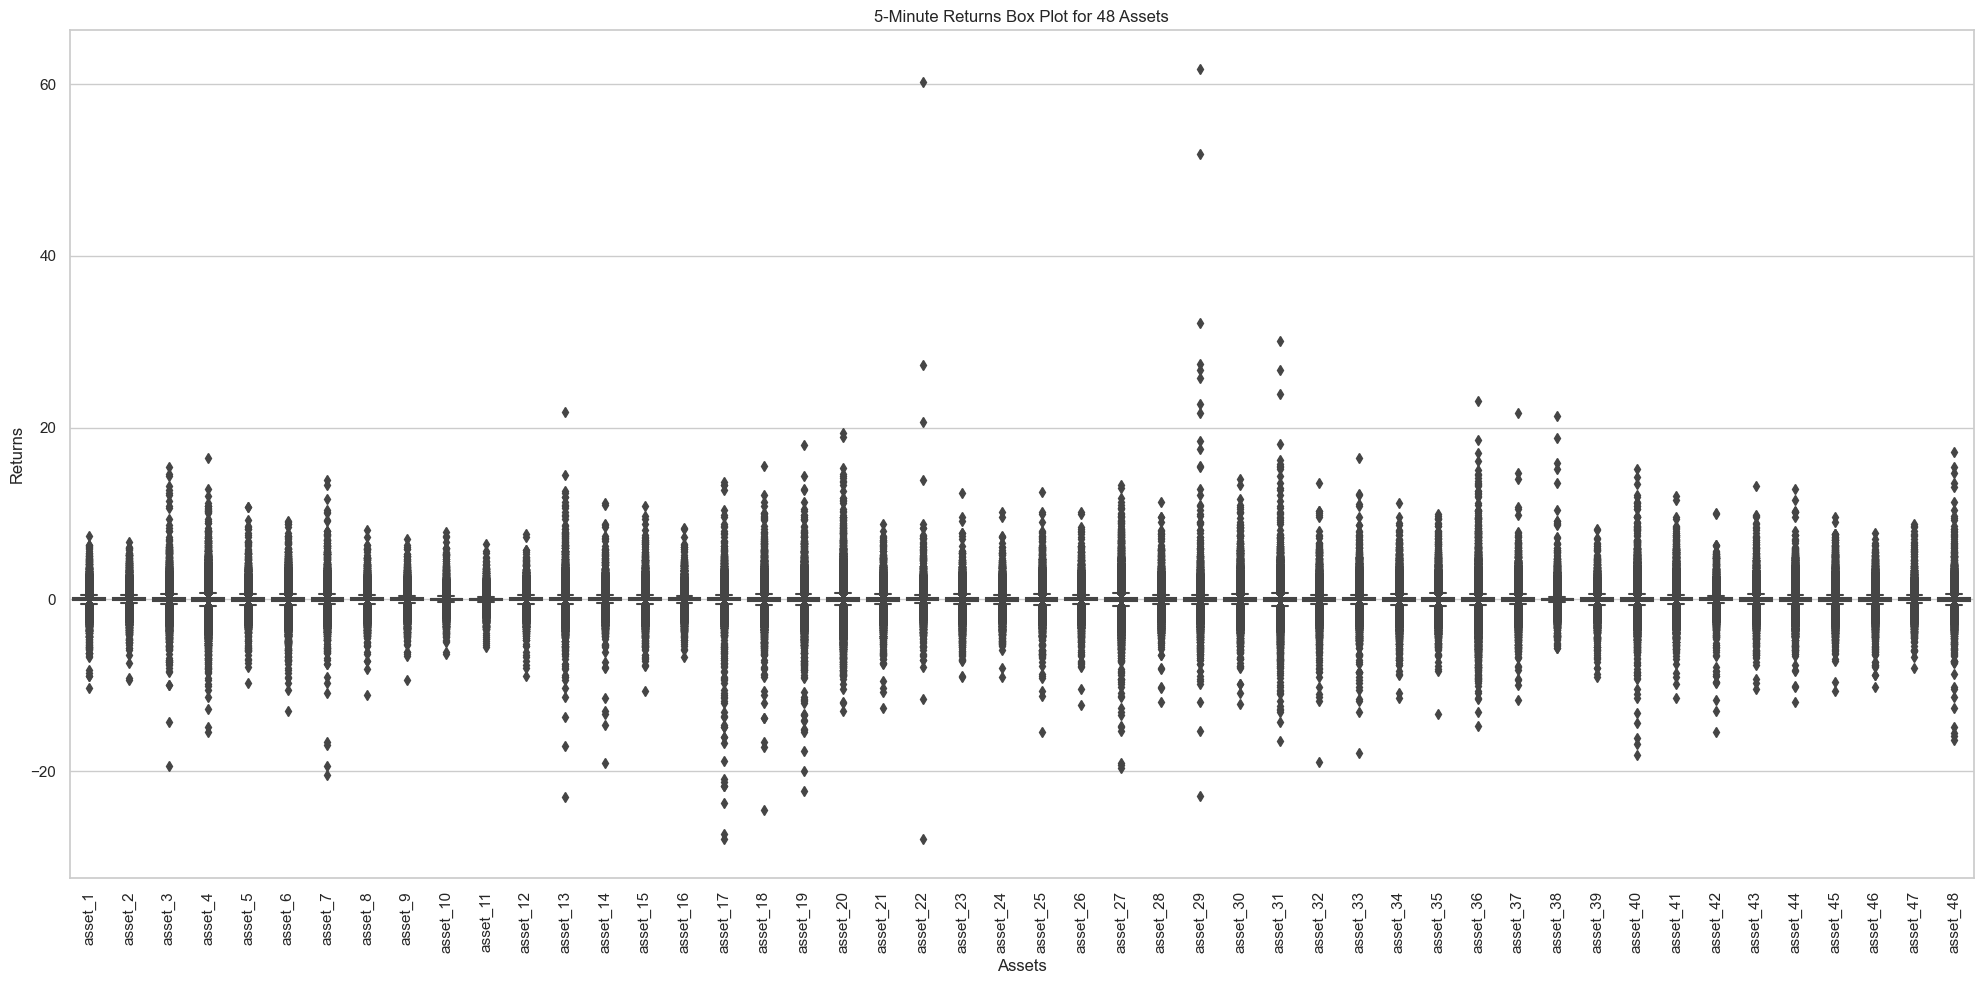

In [8]:
sns.set(style="whitegrid")

# Boxplot implemented
plt.figure(figsize=(20, 10)) 
sns.boxplot(data=rolling_returns)

plt.title('5-Minute Returns Box Plot for 48 Assets')
plt.xlabel('Assets')
plt.ylabel('Returns')

#since the x lables was too crowded, so rorate it 90 degree to make it fit.
plt.xticks(rotation=90) 
plt.tight_layout() 
plt.legend


plt.show()

#### Based on the graph, it is directly to see the box is too small to see since almost 90% of the data has small fluctuation in 5 minute time-scale, eventhough the rest the data "outside" the box is still essential and reasonable to interprete some market behaviour, so they are still important that cannot be dropped

#### After several testing, quantile and confidence interval might not adaptive since almost all the data are within the 90% range while only 1 point to show some severe financial situation happens to the market of this specific asset. (e.g. positive market news, good financial report, new investment or Merges and Aquicision)

#### It is obvious to see some outliers that reaches 60% of the return rate and -30% of return rate in 5 mintues scale

In [9]:
# Using descriptive statistic to find the base property of the return rate data.
returns_descriptive = pd.DataFrame()

for i in rolling_returns.columns:
    
    mean_value = rolling_returns[i].mean()
    median_value = rolling_returns[i].median()
    std_dev = rolling_returns[i].std()
    skewness = rolling_returns[i].skew()
    kurtosis = rolling_returns[i].kurt()

    df_temp = pd.DataFrame({
        'Asset': i,
        'Mean': mean_value,
        'Median': median_value,
        'Std Dev': std_dev,
        'Skewness': skewness,
        'Kurtosis': kurtosis
    }, index=[0])
    
    returns_descriptive = pd.concat([returns_descriptive, df_temp], ignore_index=True)

print(returns_descriptive)


       Asset      Mean    Median   Std Dev   Skewness     Kurtosis
0    asset_1 -0.001058  0.000000  0.315047  -0.334405    32.185025
1    asset_2 -0.001121  0.000000  0.296067   0.197536    30.766267
2    asset_3 -0.001083  0.000000  0.368773   0.677943    89.373394
3    asset_4  0.000148  0.000000  0.494211   0.466500    40.690420
4    asset_5 -0.000750  0.000000  0.354162   0.516874    28.081002
5    asset_6 -0.001266  0.000000  0.412921   0.038122    28.402961
6    asset_7 -0.001642  0.000000  0.371870  -0.206492    99.600790
7    asset_8 -0.001190  0.000000  0.321399   0.005258    23.651594
8    asset_9 -0.001040  0.000000  0.278838  -0.108186    27.535659
9   asset_10 -0.000278  0.000000  0.229922   0.621047    47.858520
10  asset_11 -0.000894  0.000000  0.199659   0.334432    42.550973
11  asset_12 -0.000546  0.000000  0.300139  -0.172085    22.998054
12  asset_13 -0.000078  0.000000  0.361770   0.944504   157.572006
13  asset_14 -0.001218  0.000000  0.304709  -0.748109   103.95

#### It indicates there is no need to correct the dataframe while further data cleaning is needed

## <font color=red>2. Completing</font>

In [10]:
rolling_returns.isnull().sum()

Asset_id
asset_1         5
asset_2         5
asset_3         5
asset_4     23945
asset_5         5
asset_6         5
asset_7         5
asset_8         5
asset_9         5
asset_10        5
asset_11        5
asset_12        5
asset_13        5
asset_14        5
asset_15        5
asset_16        5
asset_17        5
asset_18        5
asset_19        5
asset_20    20405
asset_21        5
asset_22        5
asset_23        5
asset_24        5
asset_25        5
asset_26        5
asset_27        5
asset_28        5
asset_29        5
asset_30        5
asset_31        5
asset_32        5
asset_33        5
asset_34        5
asset_35        5
asset_36        5
asset_37        5
asset_38        5
asset_39        5
asset_40        5
asset_41        5
asset_42        5
asset_43        5
asset_44        5
asset_45        5
asset_46        5
asset_47        5
asset_48        5
dtype: int64

In [11]:
# find the nan value for asset_4 and asset_20
column_name = 'asset_4'  

nan_positions = rolling_returns[column_name].isna()
print(nan_positions[nan_positions].index)


DatetimeIndex(['2022-03-01 00:01:00+00:00', '2022-03-01 00:02:00+00:00',
               '2022-03-01 00:03:00+00:00', '2022-03-01 00:04:00+00:00',
               '2022-03-01 00:05:00+00:00', '2022-03-01 00:06:00+00:00',
               '2022-03-01 00:07:00+00:00', '2022-03-01 00:08:00+00:00',
               '2022-03-01 00:09:00+00:00', '2022-03-01 00:10:00+00:00',
               ...
               '2022-03-17 14:56:00+00:00', '2022-03-17 14:57:00+00:00',
               '2022-03-17 14:58:00+00:00', '2022-03-17 14:59:00+00:00',
               '2022-03-17 15:00:00+00:00', '2022-03-17 15:01:00+00:00',
               '2022-03-17 15:02:00+00:00', '2022-03-17 15:03:00+00:00',
               '2022-03-17 15:04:00+00:00', '2022-03-17 15:05:00+00:00'],
              dtype='datetime64[ns, UTC]', name='Close_time', length=23945, freq=None)


In [12]:
column_name = 'asset_20'  

nan_positions = rolling_returns[column_name].isna()
print(nan_positions[nan_positions].index)

DatetimeIndex(['2022-03-01 00:01:00+00:00', '2022-03-01 00:02:00+00:00',
               '2022-03-01 00:03:00+00:00', '2022-03-01 00:04:00+00:00',
               '2022-03-01 00:05:00+00:00', '2022-03-01 00:06:00+00:00',
               '2022-03-01 00:07:00+00:00', '2022-03-01 00:08:00+00:00',
               '2022-03-01 00:09:00+00:00', '2022-03-01 00:10:00+00:00',
               ...
               '2022-03-15 03:56:00+00:00', '2022-03-15 03:57:00+00:00',
               '2022-03-15 03:58:00+00:00', '2022-03-15 03:59:00+00:00',
               '2022-03-15 04:00:00+00:00', '2022-03-15 04:01:00+00:00',
               '2022-03-15 04:02:00+00:00', '2022-03-15 04:03:00+00:00',
               '2022-03-15 04:04:00+00:00', '2022-03-15 04:05:00+00:00'],
              dtype='datetime64[ns, UTC]', name='Close_time', length=20405, freq=None)


### So we can conclude that the asset_4 and asset_20 has null value of first 17 days and 15 days due to some inevitable reason so they close the trading for these days. The best ways to handle these null value is to fill it up using the 0 number since no returning rate has been produced. .fillna(0) would be the best to interpret, as well as the first 5 rows as the starting points to estimated the 5 minutes returning rate.

In [13]:
# for the starting 5 minutes, since no references shown and 0 returning rate might be the best.
rolling_returns_completing = rolling_returns.fillna(0)

nan_counts = rolling_returns_completing.isnull().sum()
columns_with_nan = nan_counts[nan_counts > 0]

if nan_counts.any() == 0:
   print('No null values or missing data:\n')
else:
   print('Need further data completing:\n', columns_with_nan)


No null values or missing data:



## <font color=red>3. Converting</font>

## distribution and skewness

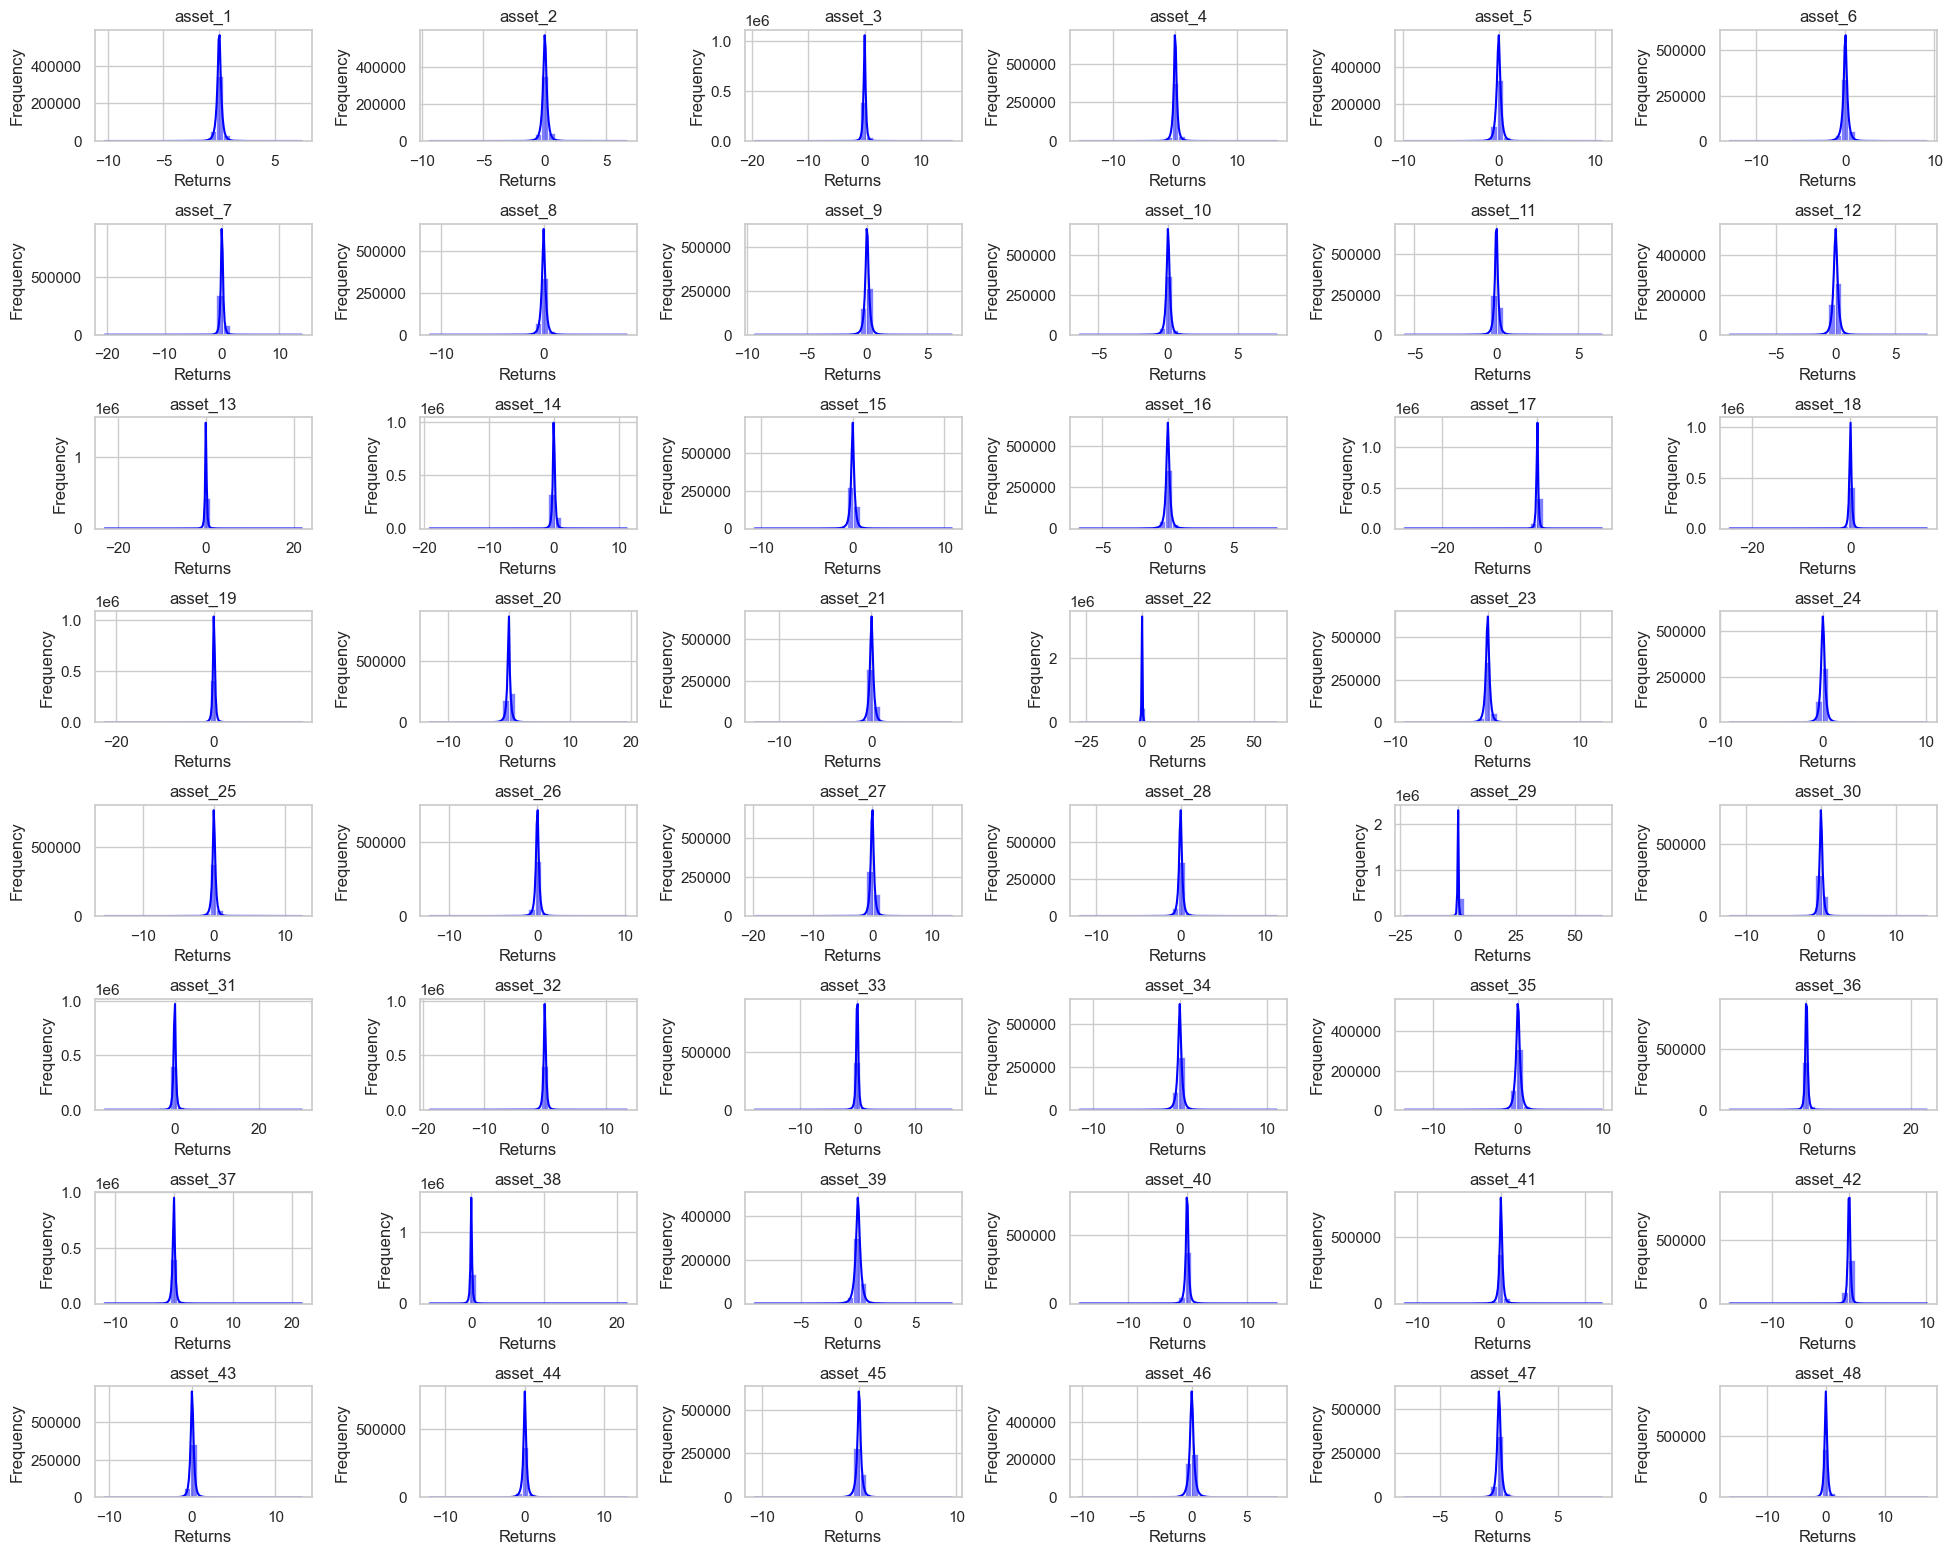

In [14]:
# Distribution of histogram and kde drawing
sns.set(style="whitegrid")

def plot_individual_distributions(data):
    fig, axes = plt.subplots(nrows=8, ncols=6, figsize=(20, 16))  
    fig.tight_layout(pad=3.0)

    # iterate all the column AKA assets for each histogram and kde graph. bins=30
    for i, column in enumerate(data.columns):
        ax = axes[i // 6][i % 6]  
        sns.histplot(data[column], kde=True, ax=ax, color="blue", bins=30)
        ax.set_title(column)
        ax.set_xlabel('Returns')
        ax.set_ylabel('Frequency')


    plt.show()

plot_individual_distributions(rolling_returns_completing)

In [15]:
# Define a function for skewness calculation
def analyze_and_list_skewness(df):
    #Skewness calculation using panda skewed
    skewness_pandas = df.skew()
    skewness_df = pd.DataFrame({
        'Pandas_Skew': skewness_pandas,
    })
    # Add blank list of assets for left and right skewed and for the further append
    left_skewed_assets = []
    right_skewed_assets = []
    
    # Iterate to find the skewed asset
    for asset in skewness_df.index:
        # use the index of each asset in the skewness calculation
        if skewness_df.loc[asset, 'Pandas_Skew'] < -1:
            left_skewed_assets.append(asset)
        if skewness_df.loc[asset, 'Pandas_Skew'] > 1:
            right_skewed_assets.append(asset)

    print(f'Left skewed assets: {left_skewed_assets}')
    print(f'Right skewed assets: {right_skewed_assets}')

analyze_and_list_skewness(rolling_returns_completing)

Left skewed assets: ['asset_17', 'asset_42']
Right skewed assets: ['asset_20', 'asset_22', 'asset_29', 'asset_30', 'asset_31', 'asset_36', 'asset_38']


### So it is trustable to say that all the asset fit for the normal distribution after the standardisation or normalization(标准化或者归一化).  described in Nayak et al., 2014
chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://www.mirlabs.org/ijcisim/regular_papers_2014/IJCISIM_24.pdf

### Z-score  might be good in this condition since the outliers cannot be ignored and may have a huge impact to the data analysis. While Min-Max may not be approapriate. Z-score are sensitive to the average and standard deviation and Min-Max are sensitive to the maximum and minimum output. 

### 做了Task3,还是觉得Z-score没问题，因为Min-max在自己的asset中表现很好，如果只有一个asset可以使用，但多个asset min-max会失真，排名会被各自最大最小值影响导致排名不理想，在用rankic的评估方法下，还是Z-score不错

In [16]:
# Z-score function defining and utilization
def standardisation_data(df):
    # apply Z-score
    standardisation_df = df.apply(zscore)
    
    return standardisation_df

standardisation_data_completing = standardisation_data(rolling_returns_completing)

# <mark>Task 3 <mark>

## 通常使用截面rank IC（把rank IC 序列按交易日计算日频均值）和IR（基于日频rank IC 数据）作为模型的评估指标。请编写评估指标函数，返回IC 序列的dataframe 和IR 值，dataframe 的index 为Close_time,columns 为IC:

#### From my perspective and reference searching https://blog.csdn.net/sinat_37574187/article/details/129471571 https://zhuanlan.zhihu.com/p/593817951 https://zhuanlan.zhihu.com/p/495755044 https://www.reddit.com/r/CFA/comments/1717ov8/information_ratio_vs_information_coefficient/ 






#### IC即信息系数（Information Coefficient），表示所选股票的因子值与股票下期收益率的截面相关系数，通过 IC 值可以判断因子值对下期收益率的预测能力。信息系数的绝对值越大，该因子越有效。IC为负表示因子值越小越好，IC为正表示因子值越大越好。IC的计算方法是：计算全部股票在调仓周期期初排名和调仓周期期末收益排名的线性相关度（Correlation）。IC越大的因子，选股能力就越强。



#### IR即信息比率（Information Ratio），是超额收益的均值与标准差之比，可以根据 IC 近似计算，公式如下。该公式是从超额收益出发，逐步推导得出的。IR= IC的多周期均值/IC的标准方差，代表因子获取稳定Alpha的能力。整个回测时段由多个调仓周期组成，每一个周期都会计算出一个不同的IC值，IR等于多个调仓周期的IC均值除以这些IC的标准方差。所以IR兼顾了因子的选股能力（由IC代表）和因子选股能力的稳定性（由IC的标准方差的倒数代表）

### 截面 Rank IC 的意义：“通常使用截面 rank IC（把 rank IC 序列按交易日计算日频均值）”，意味着每天都会计算一次 rank IC 值，这个值衡量的是在那一天内，模型预测的股票排名与实际发生的股票排名之间的相关性。这样，每个交易日都会得到一个 rank IC 值，这些值可以被视为一个时间序列，从中可以进一步计算平均值、标准差等统计量。

### 日频均值：将每天计算的 rank IC 值取平均，可以得到对模型整体预测性能的一个度量。
### 信息比率（IR）：基于日频 rank IC 数据计算得到的信息比率，是一个评估模型整体预测效果相对于其预测不确定性（表现为预测结果的波动性）的指标。

#### 所以我觉得对于每个交易日，会有48个资产的预测排名和实际排名。这些数据需要组织成两个 DataFrame：一个包含预测排名，另一个包含实际排名。这些 DataFrame 的列将对应不同的资产，行对应不同的交易日。
#### 那么这么说，对于每个交易日，会分别对这48个资产的预测排名和实际排名进行相关性分析。具体来说，用斯皮尔曼等级相关系数来衡量这些排名之间的相关性。每天计算得到的 rank IC 表示那一天模型在所有48个资产上预测正确性？？

# <font color=green>重点： 因此我觉得rank IC 测量的是两组数据排名之间的相关度。是一个金融方面的评估方法（Maybe）对评估预测值（如收益率预测）与实际结果之间的相对排序准确性，而不是绝对值的准确性。（个人想法）

### 这里有两种我决定运算的方式：
### 1. rank ic的排名，每一分钟都计算一次rank ic，一天1440次（每分钟排名一次，rank ic有1440组，再求平均值rank ic, 这样每天都会有一个IR，再把IR平均化）
### 2. 每天只用计算一次rank ic，把排名综合起来看每天的平均收益 （每天排名一次，rank ic直接求，IR按照总的时间日期计算，只有一个）

#### 我个人觉得一天计算一次rank ic比较好，计算成本较低，而每分钟的预测会过度拟合，
### <font color=red><strong>所以决定选择第二种，每天用平均排名一次日频的rank ic<strong>

### <font color=green>那我的目的就在于：
#### 1. 每分钟，将48个资产组成预测排名和实际排名的dataframe，两列，一列实际一列预测 （这里方法用one-hot?感觉dimension太大shape是（,48）,下一步再考虑）
#### 2. dataframe两列进行相关性分析，也就是用spearman coefficient来衡量相关性，就可以得到rank IC
#### 3. 把每个一分钟的时间戳的排名或者是标准值算出来，每日有1440个单位的时间戳的排名，这样求平均值就可以得到每天的平均排名，再拆开每日的datetime格式，就可得到日频均值的rank ic
#### 4. IR的分析，通过这9个月的日频均值的rank ic，这9个月的再计算rank ic的标准差，均值除以标准差即可
#### 5. 查看结果，Rank IC高说明模型表现良好，IR高说明有风险也能获得高回报

#### Normal IC and Rank IC to determine if the factor/feature is effective or not. Rank IC using Spearman coefficient.

#### IR represent the predictablity under the alpha risk

# <font color=red>操作流程：<font color=green>

#### 1. 根据每日的时间划分每日数据，把每日每个asset的标准化值求出，不用平均值，因为每个asset经历的时间一样（index是每日日期）
#### 2. actual data对每日的asset return进行排序，固定columns，但顺序数字不一样，是根据标准化的值的大小排序。每日的shape是(1,48)，e.g.[3,6,24,43,.....,2,1]
#### 3. prediction data 也是如此，每分钟预测的标准化数值聚合在每日里，rank排序
#### 4. 将actual data和prediction data 两列排好，第[0]列是Actual，第[1]列是prediction，每一列都是rank之后的，shape一样避免报错
#### 5. 用spearman rank IC 求得每日的IC，丢进dataframe里，形成dataframe 的index 为Close_time,columns 为IC
#### 6. 计算每个所有rank IC的平均值，然后标准差，计算IR
#### 7. 整合dataframe和print out

In [17]:
# Confirm if the index is DatetimeIndex for using .resampling
type(standardisation_data_completing.index)

pandas.core.indexes.datetimes.DatetimeIndex

## Acutual daily returning rate ranking

In [18]:
# Use resample as daily data and sum together for ranking the daily returning rate 
daily_data_R = standardisation_data_completing.resample('D').sum()

# Towards the columns, so .rank would be ranked among the rows AKA daily date time. ascending=False means descending from value large to small, the numbers will be from 1 to 48.
ranked_daily_data_R = daily_data_R.rank(axis='columns', ascending=False)

# Transform the dataset into list for easy implementation for ranking visualization
rank_lists_R = ranked_daily_data_R.values.tolist()


In [19]:
def calculate_ic_ir(df_test, df_pred):

    # copy to aviod editing raw dataset
    df_test_ranked = df_test.copy().resample('D').sum().rank(axis=1, ascending=False)
    df_pred_ranked = df_pred.copy().resample('D').sum().rank(axis=1, ascending=False)
    
    # daily Rank IC using spearman
    rank_ic = df_test_ranked.corrwith(df_pred_ranked, axis=1, method='spearman')
    
    # convert rank_ic to dataframe and add IC as column name and close_time as index name
    rank_ic_df = rank_ic.to_frame(name='IC')
    rank_ic_df.index.name = 'Close_time'

    # mean and standard deviation of total rank IC
    mean_ic = rank_ic.mean()
    std_ic = rank_ic.std()

    # find the IR
    if std_ic != 0: 
        rank_ir = mean_ic / std_ic
    else:
        rank_ir = float('inf') 
    return print(f"Daily Rank ICs:\n{rank_ic_df}\nDaily mean Rank IC: {mean_ic }\nIR: {rank_ir}")

In [20]:
# Show the preview
calculate_ic_ir(standardisation_data_completing,standardisation_data_completing)

Daily Rank ICs:
                            IC
Close_time                    
2022-03-01 00:00:00+00:00  1.0
2022-03-02 00:00:00+00:00  1.0
2022-03-03 00:00:00+00:00  1.0
2022-03-04 00:00:00+00:00  1.0
2022-03-05 00:00:00+00:00  1.0
...                        ...
2022-12-27 00:00:00+00:00  1.0
2022-12-28 00:00:00+00:00  1.0
2022-12-29 00:00:00+00:00  1.0
2022-12-30 00:00:00+00:00  1.0
2022-12-31 00:00:00+00:00  1.0

[306 rows x 1 columns]
Daily mean Rank IC: 1.0
IR: inf


# <mark>Task 4 <mark>

## 使用我们提供的数据构建一个预测模型，预测标签为Task1 中的收益率数据，模型评估指标为Task 3 中的IC，IR。您可以参考任何相关文献来构造特征，并最终通过模型对这些的特征进行组合，产生最终的预测结果。通常我们认为如果模型的日频rank IC>0.05 并且IR>0.5，模型是有一定预测效果的，可以尝试调节模型参数和设计其它模型，来进一步提高模型的预测效果。请特别注意：预测过程不要使用未来数据。

##### 用标准化和清理之后的值，也就是task2整理的 <font color=red>standardisation_data_completing</font> 作为收益率数据进行预测,模型评估指标是 <font color=red>calculate_ic_ir(df_real, df_pred)</font>

### <font color=green>流程：
#### 1. 数据清理，因为只在‘close’这一列进行了数据填充，那么返回到没有unstack之前的数据就会多出很多行，但只有'close'这一列有数据，那么就要进行更大范围的数据填充
#### 2. 数据填充，数据填充之后，要把数据重新填回去形成一个完整的有['Close_time', 'Asset_id', 'Open', 'High', 'Low', 'Close', 'Volume']这样格式的数据集，对于所有48个asset都可以预测。Target [Close]可以不用填充因为有已经处理好的数据
#### 3. 分test和train dataset进行预测
#### 4. model.fit做train并且用Task 3的Rank IC进行评估
#### 5. 进一步调参数，hyper-parameter Tuning，继续梳理数据集等等

In [21]:
def feature_processing(df, column_name):
    """Unstacks the given column, sorts asset columns, reindexes, and fills NaN with 0."""
    # Unstack the column and sort the asset columns based on numeric part of the asset ID
    unstacked_df = df[column_name].unstack('Asset_id')
    sorted_columns = sorted(unstacked_df.columns, key=lambda x: int(''.join([char for char in x if char.isdigit()])))
    unstacked_df = unstacked_df.reindex(columns=sorted_columns)
    # Fill NaN values with 0
    unstacked_df.fillna(0, inplace=True)
    return unstacked_df

# Example usage with a DataFrame 'df' that includes the necessary columns
# Process each column and store the results
unstacked_df_open = feature_processing(df, 'Open')
unstacked_df_high = feature_processing(df, 'High')
unstacked_df_low = feature_processing(df, 'Low')
unstacked_df_volume = feature_processing(df, 'Volume')
unstacked_df_close = feature_processing(df, 'Close')


In [22]:
# Check if it has any missing values
def check_missing_values(dataframes):
    """Check for missing values in the given list of DataFrames."""
    missing_values = {}
    for name, df in dataframes.items():
        total_missing = df.isnull().sum().sum() 
        if total_missing == 0:
            print(f"No missing values in {name}.")
        else:
            print(f"Missing values found in {name}:")
            missing_values[name] = df[df.isnull().any(axis=1)]  # for axis=1 as index row
    return missing_values

# unstacked_df_open, unstacked_df_high, unstacked_df_low, unstacked_df_volume
Unstacked_features_df = {
    'unstacked_df_open': unstacked_df_open,
    'unstacked_df_high': unstacked_df_high,
    'unstacked_df_low': unstacked_df_low,
    'unstacked_df_volume': unstacked_df_volume,
    'unstacked_df_close': unstacked_df_close
}

missing_check = check_missing_values(Unstacked_features_df)

print(missing_check)

No missing values in unstacked_df_open.
No missing values in unstacked_df_high.
No missing values in unstacked_df_low.
No missing values in unstacked_df_volume.
No missing values in unstacked_df_close.
{}


#### Dataframe Merge

In [23]:
# Combine these 5 dataframes into the original dataframe for better evaluation
# Target[standardisation_data_completing], 
# Unstacked_features_df:features:['unstacked_df_volume','unstacked_df_low','unstacked_df_high','unstacked_df_open']
# 1. Make sset_id back to column from index
stacked_df_open = unstacked_df_open.stack().rename('Open')
stacked_df_close = unstacked_df_close.stack().rename('Close')
stacked_df_high = unstacked_df_high.stack().rename('High')
stacked_df_low = unstacked_df_low.stack().rename('Low')
stacked_df_volume = unstacked_df_volume.stack().rename('Volume')
stacked_df_target = standardisation_data_completing.stack().rename('Target')

# 2. combine together
combined_stacked_df = pd.concat([stacked_df_target, stacked_df_open, stacked_df_close, stacked_df_high, stacked_df_low, stacked_df_volume], axis=1)

# 打印合并后的DataFrame查看结果
print(combined_stacked_df.head(10))


                                      Target       Open     Close       High  \
Close_time                Asset_id                                             
2022-03-01 00:01:00+00:00 asset_1   0.003360    1.50310    1.5007    1.50440   
                          asset_2   0.003785    0.96170    0.9649    0.96690   
                          asset_3   0.002935    0.07178    0.0718    0.07191   
                          asset_4  -0.000292    0.00000    0.0000    0.00000   
                          asset_5   0.002117   31.35800   31.2680   31.37300   
                          asset_6   0.003065    0.82060    0.8208    0.82180   
                          asset_7   0.004416   84.52000   84.5400   84.66000   
                          asset_8   0.003701    0.74050    0.7408    0.74160   
                          asset_9   0.003732  338.88000  339.4800  339.63000   
                          asset_10  0.001211  395.47000  395.7600  396.00000   

                                       

# <font color = green> Feature Engineering and factor(parameter) determining
#### 想法：
##### K线图选参数，量价指标
##### 先看下量化因子然后测这些因子和预测label的IC，IR然后选一些去做机器学习

#### <font color =red><strong>实现步骤：<strong>
##### <strong>1. 对一开始的几个单因子 Open Close High Low Volume 进行correlation和单个rank ic和ir的比较，看是否不经过处理的lable可以进行因子预测。需求：correlation不能太高，rankic和ir可以高一些<strong>
##### <strong>2. 根据现有数据发掘更多的因子，因此需要一些数据可视化，在这里采取K线画图，观察量和价格关系。<strong>
##### <strong>3. 观察完成之后，根据自己的想法，将现有数据结合运算创造一些correlation和rankic,ir更好的因子。<strong>
##### <strong>4. 选出几个因子，在模型预测里慢慢调试，多尝试组合，必要情况下可以对特征数据进行进一步处理，标准化或者其他<strong>





## <font color =green>参考资料：
##### 基于短周期价量特征的多因子选股体系 李辰（分析师）  刘富兵（分析师）
##### 金融科技（Fintech）和数据挖掘研究（三）——量化因子的批量生产与集中管理  分析师:冯佳睿 分析师:余浩淼 


In [24]:
# 首先对于'Open', 'High', 'Low', 'Volume'的单因子测试
# Correlation的测试

correlation_matrix = combined_stacked_df.corr()

print("Correlation Matrix:")
print(correlation_matrix)

Correlation Matrix:
          Target      Open     Close      High       Low    Volume
Target  1.000000  0.000056  0.000150  0.000114  0.000109  0.020166
Open    0.000056  1.000000  0.999999  1.000000  1.000000 -0.025135
Close   0.000150  0.999999  1.000000  1.000000  1.000000 -0.025135
High    0.000114  1.000000  1.000000  1.000000  0.999999 -0.025136
Low     0.000109  1.000000  1.000000  0.999999  1.000000 -0.025133
Volume  0.020166 -0.025135 -0.025135 -0.025136 -0.025133  1.000000


可以看到由于数据接近，open，high，low,close对于各自都有很高的相关性，而Target对于open，close,high，low的相关性很低，对于volume的相关性最高，但也很小，所以我先断定这几个不经过处理的lable因子应该不能作为最终的特征

例如：成交量最高，但其实是收的阴线，和收益率完全相反。或者说每日平均下来的其实价格没变，多空势力均衡，没有意义

或者是high的最高点很高，但其实每日平均下来的，k线有可能是冲高回落，那么就不符合high高的时候target高

#### 直接用单因子测试ICrank 和IR，来看是否合适，模型训练太长，先筛选因子

In [25]:
factor_results = {}

factors_to_test = ['Open', 'Close','High', 'Low', 'Volume']
#Iterate and output
for factor in factors_to_test:
    train_data = combined_stacked_df[factor]
    train_data = pd.DataFrame(train_data, index=train_data.index, columns=[factor])
    predictor = train_data[factor].unstack('Asset_id')
    factor_results[factor] = calculate_ic_ir(standardisation_data_completing, predictor)

for factor, result in factor_results.items():
    print(f"Factor: {factor}")
    print(result)
    print("\n")


Daily Rank ICs:
                                 IC
Close_time                         
2022-03-01 00:00:00+00:00 -0.044563
2022-03-02 00:00:00+00:00  0.332999
2022-03-03 00:00:00+00:00  0.066491
2022-03-04 00:00:00+00:00 -0.588216
2022-03-05 00:00:00+00:00 -0.129346
...                             ...
2022-12-27 00:00:00+00:00  0.193335
2022-12-28 00:00:00+00:00  0.152736
2022-12-29 00:00:00+00:00  0.262809
2022-12-30 00:00:00+00:00  0.029852
2022-12-31 00:00:00+00:00 -0.215480

[306 rows x 1 columns]
Daily mean Rank IC: 0.017421994347477484
IR: 0.07401142578796645
Daily Rank ICs:
                                 IC
Close_time                         
2022-03-01 00:00:00+00:00 -0.044563
2022-03-02 00:00:00+00:00  0.332999
2022-03-03 00:00:00+00:00  0.066491
2022-03-04 00:00:00+00:00 -0.588216
2022-03-05 00:00:00+00:00 -0.129346
...                             ...
2022-12-27 00:00:00+00:00  0.193335
2022-12-28 00:00:00+00:00  0.152736
2022-12-29 00:00:00+00:00  0.262809
2022-12-30 00:0

#### 可以看到所有的单个因子直接放入的话IR和IC值很低很低，所以需要特征工程去筛选合适的特征或者特征组合来达到更高的IC rank和IR值

### <font color = green>需要更多的因子挖掘！！！找到模型适配，build and compose这些factors

### K线可视化
#### 观察日k和5分钟k也许有帮助，这里用到了金融包mplfinance来画k

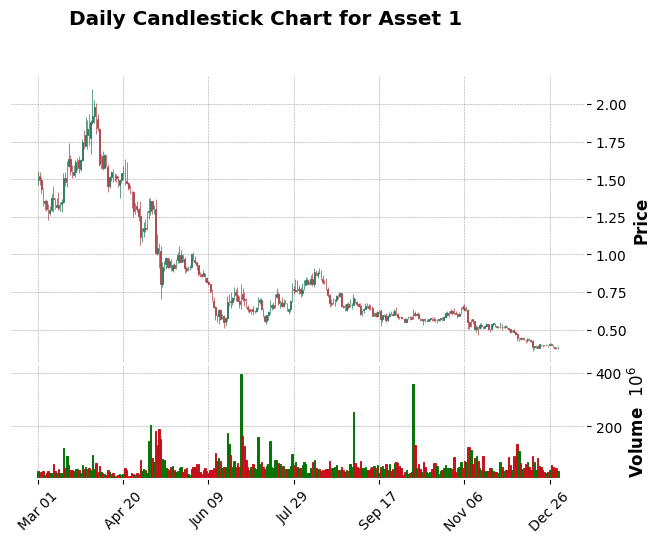

In [26]:
asset_data_1 = combined_stacked_df.xs('asset_1', level=1, drop_level=False)

# 核心！！！！！改转换时间索引为DatetimeIndex
asset_data_1.index = pd.to_datetime(asset_data_1.index.get_level_values('Close_time'))

# aggregate到每日数据
daily_data_1 = asset_data_1.resample('D').agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Volume': 'sum'
})

mpf.plot(daily_data_1, type='candle', volume=True, style='charles', title="Daily Candlestick Chart for Asset 1")


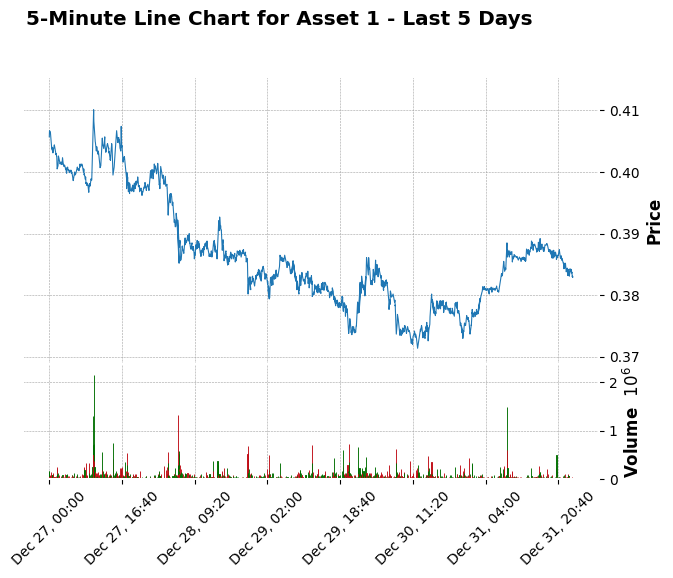

In [27]:
# Last 5 days of 5 minutes Line chart for asset_1
asset_data_1_5m = combined_stacked_df.xs('asset_1', level=1, drop_level=True)
asset_data_1_5m = asset_data_1_5m.copy()
asset_data_1_5m.index = pd.to_datetime(asset_data_1_5m.index.get_level_values('Close_time'))
asset_data_1_5m.sort_index(inplace=True)
last_five_days_1 = asset_data_1_5m.last('5D')

mpf.plot(last_five_days_1, type='line', volume=True, style='charles', title="5-Minute Line Chart for Asset 1 - Last 5 Days", show_nontrading=False)


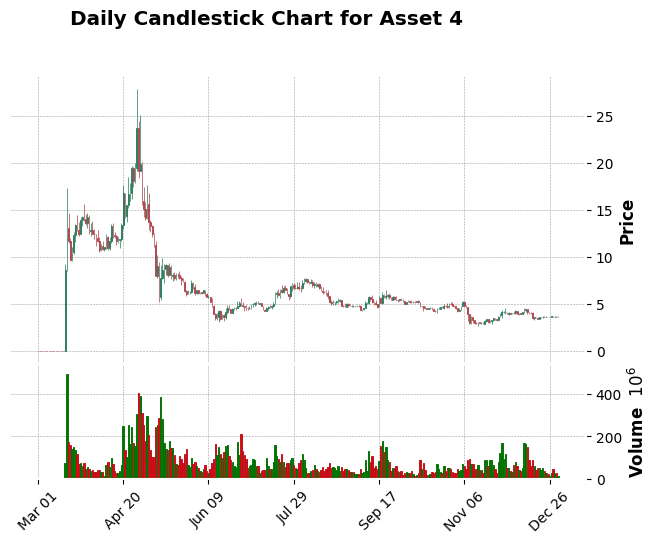

In [28]:
# Daily Candle stick chart for Asset_4
asset_data_4 = combined_stacked_df.xs('asset_4', level=1, drop_level=False)
asset_data_4.index = pd.to_datetime(asset_data_4.index.get_level_values('Close_time'))
daily_data_4 = asset_data_4.resample('D').agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Volume': 'sum'
})

mpf.plot(daily_data_4, type='candle', volume=True, style='charles', title="Daily Candlestick Chart for Asset 4")


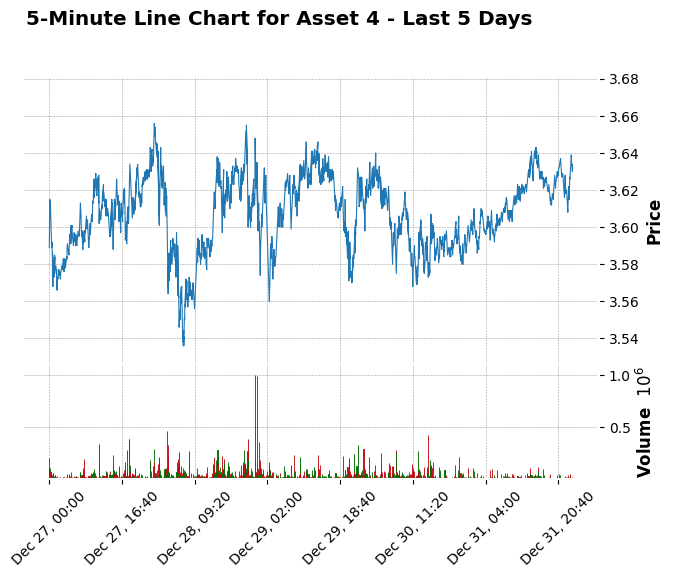

In [29]:
# Last 5 days of 5 minutes Line chart for asset_4
asset_data_4_5m = combined_stacked_df.xs('asset_4', level=1, drop_level=True)
asset_data_4_5m = asset_data_4_5m.copy()
asset_data_4_5m.index = pd.to_datetime(asset_data_4_5m.index.get_level_values('Close_time'))
asset_data_4_5m.sort_index(inplace=True)
last_five_days_4 = asset_data_4_5m.last('5D')

mpf.plot(last_five_days_4, type='line', volume=True, style='charles', title="5-Minute Line Chart for Asset 4 - Last 5 Days", show_nontrading=False)


#### 在这里，我感觉量价关系很重要，巨量总是伴随巨大波动，可能对于收益率很有关系。
#### 在已有数据open，close,high，low和volume的基础上发掘，
#### 例如巨大的量但是价格相比降低了，那么收阴线就是流出，结果可以表现在收益率为负上。


交易量的关系系数比较大，说明是有一定联系的，但数值太大对于float来说不好预测，那就用百分比的volume change以及和量价关系有关系的因子作为预测

#### 初筛的因子：'Volume_Change_Rate' 'Price_Volume_Ratio' 'Price_Volume' 'Price_Volatility' 'MA5' 'OBV' 'ROC' 'VWAP' 'OBV_change_rate'
#### 进行筛选：
#### <font color = green>最后决定的因子：'Price_Volume_Ratio', 'VWAP', 'Volume_Change_Rate'

In [30]:
#价格变化率：计算相邻两个时刻的价格变化率，即收盘价与开盘价之间的差异，(close-open)/open
combined_stacked_df['Price_Change_Rate'] = (combined_stacked_df['Close'] - combined_stacked_df['Open']) / combined_stacked_df['Open']

#价格波动率：计算一定时间内的价格波动率，例如收盘价的标准差。
combined_stacked_df['Price_Volatility'] = combined_stacked_df['Close'].rolling(window=20).std()

#成交量变化率：计算相邻两个时刻的成交量变化率，即当前成交量与上一时刻成交量之间的差异。
combined_stacked_df['Volume_Change_Rate'] = combined_stacked_df['Volume'].pct_change()

#价格与成交量比例：计算价格和成交量之间的比例关系，可能会反映出市场的买卖力量。
combined_stacked_df['Price_Volume_Ratio'] = combined_stacked_df['Close'] / combined_stacked_df['Volume']

# MA 5 of close
combined_stacked_df['MA5'] = combined_stacked_df['Close'].rolling(window=5).mean()

# OBV
combined_stacked_df['OBV'] = (combined_stacked_df['Volume'] * ((combined_stacked_df['Close'] > combined_stacked_df['Close'].shift(1)) * 2 - 1)).cumsum()

# ROC - Rate of Change
combined_stacked_df['ROC'] = combined_stacked_df['Close'].pct_change(periods=10) * 100

# VWAP Volume Weighted Average Price
combined_stacked_df['Typical_Price'] = (combined_stacked_df['High'] + combined_stacked_df['Low'] + combined_stacked_df['Close']) / 3

# Price_volume
combined_stacked_df['Price_Volume'] = combined_stacked_df['Typical_Price'] * combined_stacked_df['Volume']
combined_stacked_df['VWAP'] = combined_stacked_df.groupby('Asset_id')['Price_Volume'].cumsum() / combined_stacked_df.groupby('Asset_id')['Volume'].cumsum()

# OBV_change
combined_stacked_df['OBV_change_rate'] = (combined_stacked_df['OBV'].diff() / combined_stacked_df['OBV'].shift(1)) * 100

# 替换 NaN 值为 0
combined_stacked_df.fillna(0, inplace=True)

# 替换正无限和负无限值为 0
combined_stacked_df.replace([np.inf, -np.inf], 0, inplace=True)

#以下转换predictor因子进行rankic，ir测试
predictor1= pd.DataFrame(combined_stacked_df['Price_Change_Rate'], index=combined_stacked_df.index, columns=['Price_Change_Rate'])
predictor1 = predictor1['Price_Change_Rate'].unstack('Asset_id')

predictor2= pd.DataFrame(combined_stacked_df['Price_Volatility'], index=combined_stacked_df.index, columns=['Price_Volatility'])
predictor2 = predictor2['Price_Volatility'].unstack('Asset_id')

predictor3= pd.DataFrame(combined_stacked_df['Volume_Change_Rate'], index=combined_stacked_df.index, columns=['Volume_Change_Rate'])
predictor3 = predictor3['Volume_Change_Rate'].unstack('Asset_id')

predictor4= pd.DataFrame(combined_stacked_df['Price_Volume_Ratio'], index=combined_stacked_df.index, columns=['Price_Volume_Ratio'])
predictor4 = predictor4['Price_Volume_Ratio'].unstack('Asset_id')

predictor5= pd.DataFrame(combined_stacked_df['MA5'], index=combined_stacked_df.index, columns=['MA5'])
predictor5 = predictor5['MA5'].unstack('Asset_id')

predictor6= pd.DataFrame(combined_stacked_df['OBV'], index=combined_stacked_df.index, columns=['OBV'])
predictor6 = predictor6['OBV'].unstack('Asset_id')

predictor7= pd.DataFrame(combined_stacked_df['ROC'], index=combined_stacked_df.index, columns=['ROC'])
predictor7 = predictor7['ROC'].unstack('Asset_id')

predictor8 = pd.DataFrame(combined_stacked_df['VWAP'], index=combined_stacked_df.index, columns=['VWAP'])
predictor8 = predictor8['VWAP'].unstack('Asset_id')

predictor9 = pd.DataFrame(combined_stacked_df['Price_Volume'], index=combined_stacked_df.index, columns=['Price_Volume'])
predictor9 = predictor9['Price_Volume'].unstack('Asset_id')

predictor10= pd.DataFrame(combined_stacked_df['OBV_change_rate'], index=combined_stacked_df.index, columns=['OBV_change_rate'])
predictor10 = predictor10['OBV_change_rate'].unstack('Asset_id')

In [31]:
print(calculate_ic_ir(standardisation_data_completing, predictor1), calculate_ic_ir(standardisation_data_completing, predictor2),calculate_ic_ir(standardisation_data_completing, predictor3),
      calculate_ic_ir(standardisation_data_completing, predictor4), calculate_ic_ir(standardisation_data_completing, predictor5))

Daily Rank ICs:
                                 IC
Close_time                         
2022-03-01 00:00:00+00:00  0.846256
2022-03-02 00:00:00+00:00  0.865362
2022-03-03 00:00:00+00:00  0.843217
2022-03-04 00:00:00+00:00  0.738133
2022-03-05 00:00:00+00:00  0.645968
...                             ...
2022-12-27 00:00:00+00:00  0.713851
2022-12-28 00:00:00+00:00  0.650130
2022-12-29 00:00:00+00:00  0.693009
2022-12-30 00:00:00+00:00  0.720039
2022-12-31 00:00:00+00:00  0.409357

[306 rows x 1 columns]
Daily mean Rank IC: 0.7739802916803116
IR: 6.7611465249687175
Daily Rank ICs:
                                 IC
Close_time                         
2022-03-01 00:00:00+00:00 -0.077182
2022-03-02 00:00:00+00:00  0.207664
2022-03-03 00:00:00+00:00 -0.168584
2022-03-04 00:00:00+00:00 -0.157186
2022-03-05 00:00:00+00:00 -0.132002
...                             ...
2022-12-27 00:00:00+00:00 -0.407295
2022-12-28 00:00:00+00:00  0.005970
2022-12-29 00:00:00+00:00  0.140578
2022-12-30 00:00:0

In [32]:
print(calculate_ic_ir(standardisation_data_completing, predictor6),
      calculate_ic_ir(standardisation_data_completing, predictor7),calculate_ic_ir(standardisation_data_completing, predictor8), 
      calculate_ic_ir(standardisation_data_completing, predictor9),calculate_ic_ir(standardisation_data_completing, predictor10) )

Daily Rank ICs:
                                 IC
Close_time                         
2022-03-01 00:00:00+00:00  0.049938
2022-03-02 00:00:00+00:00  0.163763
2022-03-03 00:00:00+00:00 -0.174727
2022-03-04 00:00:00+00:00 -0.267872
2022-03-05 00:00:00+00:00 -0.080009
...                             ...
2022-12-27 00:00:00+00:00 -0.026270
2022-12-28 00:00:00+00:00  0.156644
2022-12-29 00:00:00+00:00  0.076856
2022-12-30 00:00:00+00:00  0.002714
2022-12-31 00:00:00+00:00  0.189535

[306 rows x 1 columns]
Daily mean Rank IC: 0.01641854130155785
IR: 0.11104737706555166
Daily Rank ICs:
                                 IC
Close_time                         
2022-03-01 00:00:00+00:00  0.292615
2022-03-02 00:00:00+00:00  0.213700
2022-03-03 00:00:00+00:00  0.012159
2022-03-04 00:00:00+00:00 -0.306519
2022-03-05 00:00:00+00:00 -0.052706
...                             ...
2022-12-27 00:00:00+00:00  0.217868
2022-12-28 00:00:00+00:00  0.102909
2022-12-29 00:00:00+00:00  0.155884
2022-12-30 00:00

1. 移动平均线 (Moving Averages)
简单移动平均线 (SMA) 和 指数移动平均线 (EMA)：平滑价格数据以展示趋势方向。EMA对近期价格变化更敏感。
3. 成交量加权平均价格 (VWAP)
基于成交量的加权平均价格，特别适合短期交易。它提供了一个交易日内相对于成交量的价格平均值，对于5分钟级别的交易非常有用。
4. 成交量
OBV (On-Balance Volume)：使用成交量流动来预测价格变动的方向。
Accumulation/Distribution Line (A/D Line)：考虑到收盘价在当天价格范围的位置，与成交量相结合来判断价格的未来走势。
6. MACD (Moving Average Convergence Divergence)
显示两个移动平均线之间的关系，帮助识别价格动向的变化点。
8. Price Rate of Change (ROC)
显示价格相对于之前某个时期的变化率。

In [33]:
#多因子关系
correlation_matrix = combined_stacked_df.corr()

print("Correlation Matrix:")
print(correlation_matrix)

Correlation Matrix:
                      Target      Open     Close      High       Low  \
Target              1.000000  0.000056  0.000150  0.000114  0.000109   
Open                0.000056  1.000000  0.999999  1.000000  1.000000   
Close               0.000150  0.999999  1.000000  1.000000  1.000000   
High                0.000114  1.000000  1.000000  1.000000  0.999999   
Low                 0.000109  1.000000  1.000000  0.999999  1.000000   
Volume              0.020166 -0.025135 -0.025135 -0.025136 -0.025133   
Price_Change_Rate   0.436506 -0.000125  0.000032 -0.000035 -0.000042   
Price_Volatility    0.000445  0.179519  0.179519  0.179510  0.179527   
Volume_Change_Rate  0.007723 -0.002685 -0.002685 -0.002685 -0.002685   
Price_Volume_Ratio  0.000110  0.073384  0.073385  0.073369  0.073400   
MA5                 0.000293  0.414617  0.414617  0.414612  0.414621   
OBV                 0.000562  0.064260  0.064260  0.064278  0.064242   
ROC                 0.000030  0.382678  0.38

# <font color = green>Test set and Train set randomly choosing

# <font color=red> <strong>在最后的模型预测中，有306天，经过测试，如果test和train数据集随机采取x天数的话，预测的效果很不好，因此test和train的dataset需要按照顺序的日期来，以‘day’为基础划分每一个时间戳，也就是一天1440个分钟集合，每一天的return的.sum()决定排名<strong>

#### 从总数据随机选30天，再在30天内随机选24天作为train set，剩下6天作为test set

## <font color = green>1. total_days是总天数len(unique_dates) = 306天，随机选80%作为train set，剩下20%作为test set 这种方法测试模型的各种情况数据集的robust，证明了模型的泛化能力对于不同时间段抽取trainset和test的影响，在测试中，10次的随机采样20%的日期作为test set和剩余80%的train set可以达到6次的rank ic和ir达标，那么可以说明泛化能力基本达标。

## 具体要看第三类的分发，也就是具体模型的实现

In [34]:
#确定加#关闭或开启随机数
#np.random.seed(666)

# 核心！！！！！花了很长时间改。。。创建日期 Series 对象，确保索引与原始 DataFrame 相同
#date_series = pd.Series(pd.to_datetime(combined_stacked_df.index.get_level_values('Close_time')).date, index=combined_stacked_df.index)

# 计算去重后的日期并排序
# unique_dates = np.sort(date_series.unique())

# 计算总天数和需要的样本天数
# total_days = len(unique_dates)
# sample_days_test = int(total_days * 0.2)

# 确保样本天数至少为 1，防止因为小数而得到 0
# sample_days_test = max(sample_days_test, 1)

# 随机选择一个起始索引，确保能选择到连续的天数,并且total_days - (sample_days_test - 1)确保了索引不超过最大日期，
# start_index_test = np.random.randint(0, total_days - sample_days_test + 1)
# selected_dates_test = unique_dates[start_index_test:start_index_test + sample_days_test]
# selected_data_test = combined_stacked_df[date_series.isin(selected_dates_test)]

# setfidd1d把20%剔除之后剩下的即为80%的train set
# remaining_dates = np.setdiff1d(unique_dates, selected_dates_test)

# 根据剩下的日期选择数据
# selected_data_train = combined_stacked_df[date_series.isin(remaining_dates)]

# 分开test和train测试集
# train_data = selected_data_train[['Price_Volume_Ratio', 'VWAP', 'Volume_Change_Rate']]
# train_data = pd.DataFrame(train_data, index=train_data.index, columns=['Price_Volume_Ratio', 'VWAP', 'Volume_Change_Rate'])

# test_data = selected_data_test[['Price_Volume_Ratio', 'VWAP', 'Volume_Change_Rate']]
# test_data = pd.DataFrame(test_data, index=test_data.index, columns=['Price_Volume_Ratio', 'VWAP', 'Volume_Change_Rate'])

# train_target = selected_data_train['Target']
# train_target = pd.DataFrame(train_target, index=train_target.index, columns=['Target'])

# test_target = selected_data_test['Target']
# test_target = pd.DataFrame(test_target, index=test_target.index, columns=['Target'])



## <font color = green>2. total_days是总天数中，随机选的30天 ，里面再随机选24天是train(测试模型用，跑代码时间太长)

In [35]:
#确定加#关闭或开启随机数
#np.random.seed(666)

# 计算需要随机选择的样本天数
# sample_days1 = 30
# sample_days2 = 6

# 随机选择30天的连续天数
# start_index_1 = np.random.randint(0, total_days - sample_days1 + 1)
# selected_dates_1 = unique_dates[start_index_1:start_index_1 + sample_days1]

# 在选取的30天中随机选择6天作为最终样本天数
# start_index_2 = np.random.randint(0, sample_days1 - sample_days2 + 1)
# selected_dates_2 = selected_dates_1[start_index_2:start_index_2 + sample_days2]

# 根据选取的日期选择数据
# selected_data_ez = combined_stacked_df[date_series.isin(selected_dates_2)]

# 剔除已选取的6天，获取剩下的24天作为train
# remaining_dates = [date for date in selected_dates_1 if date not in selected_dates_2]

# 根据剩下的日期选择数据
# remaining_data_ez = combined_stacked_df[date_series.isin(remaining_dates)]

# train_data = remaining_data_ez[['Price_Volume_Ratio', 'VWAP', 'Volume_Change_Rate']]
# train_data = pd.DataFrame(train_data, index=train_data.index, columns=['Price_Volume_Ratio', 'VWAP', 'Volume_Change_Rate'])

# test_data = selected_data_ez[['Price_Volume_Ratio', 'VWAP', 'Volume_Change_Rate']]
# test_data = pd.DataFrame(test_data, index=test_data.index, columns=['Price_Volume_Ratio', 'VWAP', 'Volume_Change_Rate'])

# train_target = remaining_data_ez['Target']
# train_target = pd.DataFrame(train_target, index=train_target.index, columns=['Target'])

# test_target = selected_data_ez['Target']
# test_target = pd.DataFrame(test_target, index=test_target.index, columns=['Target'])


# print(remaining_data_ez.head())
# print(selected_data_ez.head())


In [36]:
#这种方法我测试了很多方向无法实现，因为是时间序列的时间戳，如果单纯split的话全是乱时间，所以要使用以上代码分开数据集test和train
#from sklearn.model_selection import train_test_split
# after choosing the 'target' column, the column data would be transferred to series rathe than dataframe. For better evaluation setting in task 3, it needed to be converted to dataframe 
# by pd.Dataframe
#target_df = pd.DataFrame(selected_data['Target'])

#train_data, test_data, train_target, test_target = train_test_split(selected_data.drop(columns=['Target','Open', 'High','Low']), target_df, test_size=0.2, random_state=666)

## <font color = green>3. total_days是总天数len(unique_dates) = 306天中，由于强时间序列的关系，前后的金融数据会有很大的影响，因此只把最后的20%当作test set，前80%作为train set，进行预测

In [37]:
# 确定随机数种子，如果需要可开启
# np.random.seed(666)

# 创建日期 Series 对象，确保索引与原始 DataFrame 相同
date_series = pd.Series(pd.to_datetime(combined_stacked_df.index.get_level_values('Close_time')).date, index=combined_stacked_df.index)

# 计算去重后的日期并排序
unique_dates = np.sort(date_series.unique())

# 计算总天数和测试集需要的样本天数
total_days = len(unique_dates)
sample_days_test = int(total_days * 0.2)

# 确保样本天数至少为 1，防止因为小数而得到 0
sample_days_test = max(sample_days_test, 1)

# 选择最后20%的日期作为测试集
selected_dates_test = unique_dates[-sample_days_test:]
selected_data_test = combined_stacked_df[date_series.isin(selected_dates_test)]

# 选择前80%的日期作为训练集
remaining_dates = unique_dates[:-sample_days_test]
selected_data_train = combined_stacked_df[date_series.isin(remaining_dates)]

# 分别为训练集和测试集（代码有点烂）
train_data = selected_data_train[['Price_Volume_Ratio', 'VWAP', 'Volume_Change_Rate']]
train_data = pd.DataFrame(train_data, index=train_data.index, columns=['Price_Volume_Ratio', 'VWAP', 'Volume_Change_Rate'])

test_data = selected_data_test[['Price_Volume_Ratio', 'VWAP', 'Volume_Change_Rate']]
test_data = pd.DataFrame(test_data, index=test_data.index, columns=['Price_Volume_Ratio', 'VWAP', 'Volume_Change_Rate'])

train_target = selected_data_train['Target']
train_target = pd.DataFrame(train_target, index=train_target.index, columns=['Target'])

test_target = selected_data_test['Target']
test_target = pd.DataFrame(test_target, index=test_target.index, columns=['Target'])

## <font color=green> Model Fit
#### 在这个阶段，我将会使用
##### 1. LSTM作为神经网络模型来预测，我会将dataframe转换成numpy模式，这个情况下shape可能是3d的samples, time steps, features，然后首先需要用min-max对数据进行缩放的预处理，得出结论后我会把输出再转换回来，从numpy转换成dataframe，这样就可以进行Task3的calculate_ic_ir的模型评估。
##### 2. 聚合了RandomForest，XGBClassifier,LGBMClassifier的随机森林，xgboost和lightgbm方法，称之为machine learning Aggregator（MLA）哈哈哈哈，再统一用calculate_ic_ir进行模型评估。
##### 3. 进行比较，看哪个模型表现较好，我再进行进一步的超参调试。

In [38]:
#神经网络的预测应该是可行的, 但我的shape转换等等没有做到很好, dataframe reshape回来也是一团糟, 而且机器也跑不动, 所以这个方法暂留
# LSTM
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense
# scaling
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled_train_data = scaler.fit_transform(train_data)
# scaled_test_data = scaler.transform(test_data)

# reshape
# scaled_train_data = scaled_train_data.reshape(scaled_train_data.shape[0], 1, scaled_train_data.shape[1])
# scaled_test_data = scaled_test_data.reshape(scaled_test_data.shape[0], 1, scaled_test_data.shape[1])

#Model compile using adam
# lstm_model = Sequential()
# lstm_model.add(LSTM(50, input_shape=(scaled_train_data.shape[1], scaled_train_data.shape[2])))
# lstm_model.add(Dense(1))
# lstm_model.compile(loss='mean_squared_error', optimizer='adam')

#Model fit
# lstm_model.fit(scaled_train_data, train_target, epochs=50, batch_size=72, verbose=2, shuffle=False)
# lstm_predictions = lstm_model.predict(scaled_test_data)

# convert to dataframe
# lstm_predictions_df = pd.DataFrame(lstm_predictions, columns=['Predictions'])
# lstm_predictions_df.index = test_target.index  # 确保索引与 test_target 一致

# evaluation
# calculate_ic_ir(test_target, lstm_predictions_df)

# 文献：https://www.kaggle.com/code/ldfreeman3/a-data-science-framework-to-achieve-99-accuracy#Step-5:-Model-Data
# Stock Selection Model Based on Random Fores by Chenyao Ma

### MLA = [

###    RandomForestRegressor(),

###    XGBRegressor(),

###    LGBMRegressor()

###       ]

# <font color = green>RandomForestRegressor Testing （经过测试，测试效果不佳，更换模型）

### 先用总天数的2：8的test:train，来随机选择一个因子进行模型fit，这里用的是'Volume'固定变量，来看看calculate_ic_ir的结果如何，筛选模型先，注意：这里的因子不是最终结果，最终模型还在后面

In [39]:
# 将目标变量转换为一维数组
# train_target_flat = train_target.values.ravel()

# 配置 RandomForestRegressor 模型
# model = RandomForestRegressor(n_estimators=100, max_depth=5, min_samples_leaf=1, random_state=666, n_jobs=-1)

# 训练模型
# model.fit(train_data, train_target_flat)

# 在测试集上进行预测
# predictions_rf = model.predict(test_data)

# 预测结果转换为 DataFrame
# predictions_df_rf = pd.DataFrame(predictions_rf, index=test_data.index, columns=['Predictions'])
# predictions_df_rf = predictions_df_rf['Predictions'].unstack('Asset_id')

# 测试目标也转换为 DataFrame 以匹配预测格式
# test_target_df = pd.DataFrame(test_target, index=test_data.index)
# test_target_df = test_target_df['Target'].unstack('Asset_id')

# calculate_ic_ir(test_target_df, predictions_df_rf)

# <font color = green> XGBRegressor Testing 最好但不快，次选

In [40]:
# model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=66,n_jobs=-1)

# 训练模型
# model.fit(train_data, train_target)

# 在测试集上进行预测
# predictions_xgb = model.predict(test_data)

# 预测结果转换为 DataFrame
# predictions_df_xgb = pd.DataFrame(predictions_xgb, index=test_data.index, columns=['Predictions'])
# predictions_df_xgb = predictions_df_xgb['Predictions'].unstack('Asset_id')

# 测试目标也转换为 DataFrame 以匹配预测格式
# test_target_df = pd.DataFrame(test_target, index=test_data.index)
# test_target_df = test_target_df['Target'].unstack('Asset_id')

# calculate_ic_ir(test_target_df, predictions_df_xgb)


# <font color = green> LGBMRegressor Testing 最快但不是最好，但一点点loss可以提高30%的速度可以忍受，

决定的因子：'Volume_Change_Rate', 'Price_Volume_Ratio', 'Price_Volume','VWAP', 'OBV_change_rate'

参数优化：经过下面的筛选以及Hyper-parameter Tuning 超参调试，主要更新了以下的参数num_leaves, learning_rate, n_estimators, max_depth

In [45]:
# 配置 LGBMRegressor 模型
final_model_lgbm = LGBMRegressor(num_leaves=51, learning_rate=0.1, n_estimators=100, random_state=66, n_jobs=-1)

# 训练模型
final_model_lgbm.fit(train_data, train_target)

# 在测试集上进行预测
predictions_lgbm = final_model_lgbm.predict(test_data)

# 预测结果转换为 DataFrame
predictions_df_lgbm = pd.DataFrame(predictions_lgbm, index=test_data.index, columns=['Predictions'])
predictions_df_lgbm = predictions_df_lgbm['Predictions'].unstack('Asset_id')

# 测试目标也转换为 DataFrame 以匹配预测格式
test_target_df = pd.DataFrame(test_target, index=test_data.index)
test_target_df = test_target_df['Target'].unstack('Asset_id')

calculate_ic_ir(test_target_df, predictions_df_lgbm)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.071431 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 16934352, number of used features: 3
[LightGBM] [Info] Start training from score 0.000895
Daily Rank ICs:
                                 IC
Close_time                         
2022-11-01 00:00:00+00:00  0.387647
2022-11-02 00:00:00+00:00  0.122666
2022-11-03 00:00:00+00:00  0.115176
2022-11-04 00:00:00+00:00  0.068715
2022-11-05 00:00:00+00:00 -0.040599
...                             ...
2022-12-27 00:00:00+00:00  0.088037
2022-12-28 00:00:00+00:00  0.184759
2022-12-29 00:00:00+00:00  0.212223
2022-12-30 00:00:00+00:00  0.041359
2022-12-31 00:00:00+00:00  0.159900

[61 rows x 1 columns]
Daily mean Rank IC: 0.07690610251774235
IR: 0.5484270682972376


In [42]:
#Final Model
final_model_lgbm

LGBMRegressor(n_jobs=-1, num_leaves=51, random_state=66)

## <font color = green>因子调试和选择
##### 'Price_Volume_Ratio'
##### Daily mean Rank IC: 0.043304172035050506
##### IR: 0.29343138306460365
\\
\\

##### 'VWAP'
##### Daily mean Rank IC: 0.03889574152168691
##### IR: 0.24538021776773247
\\
\\
##### 'OBV_change_rate'
##### Daily mean Rank IC: 0.031365005018400796
##### IR: 0.1997060239498803
\\
\\
##### 'Price_Volume'
##### Daily mean Rank IC: 0.023917484677861374
##### IR: 0.13861912261099224
\\
\\
##### 'Volume_Change_Rate'
##### Daily mean Rank IC: 0.017080358477538207
##### IR: 0.1074169707735503
\\
\\
##### 'Price_Volume_Ratio', 'VWAP'
##### [61 rows x 1 columns]
##### Daily mean Rank IC: 0.061982588640618425
##### IR: 0.3310834210871974
\\
\\
##### 'Volume_Change_Rate', 'Price_Volume_Ratio', 'Price_Volume', 'VWAP', 'OBV_change_rate'
##### Daily mean Rank IC: 0.0638974110746496
##### IR: 0.3895415272260767
\\
\\
##### 'Price_Volume_Ratio', 'VWAP', 'Volume_Change_Rate', 'Price_Volume'
##### Daily mean Rank IC: 0.06910266722663953
##### IR: 0.4160968085909605
\\
\\
##### <font color = red>'Price_Volume_Ratio', 'VWAP', 'Volume_Change_Rate'
##### Daily mean Rank IC: 0.06408782557320103
##### IR: 0.4600527531193744













# Hyper-parameter Tuning 超参调试

In [43]:
# from sklearn.model_selection import RandomizedSearchCV

# param_grid = {
#    'num_leaves': [ 30, 40, 50],  # 叶子节点数量
#    'learning_rate': [0.01, 0.05, 0.1],  # 学习率
#    'n_estimators': [100, 150],  # 树的数量
# }

# model = LGBMRegressor(random_state=66, n_jobs=-1)

# 创建RandomizedSearchCV对象
# random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=50, cv=5, scoring='neg_mean_squared_error', random_state=66, n_jobs=-1)

# 执行随机搜索
# random_search.fit(train_data, train_target)

# 打印最佳参数组合
# print("Best parameters found: ", random_search.best_params_)

# 获取最佳模型
# best_model = random_search.best_estimator_

# 在测试集上进行预测
# predictions_lgbm = best_model.predict(test_data)

# 预测结果转换为 DataFrame
# predictions_df_lgbm = pd.DataFrame(predictions_lgbm, index=test_data.index, columns=['Predictions'])
# predictions_df_lgbm = predictions_df_lgbm['Predictions'].unstack('Asset_id')

# calculate_ic_ir(test_target_df, predictions_df_lgbm)